<a href="https://colab.research.google.com/github/dnf6541/ME592FinalProject/blob/main/training_wavy_64x64_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import datasets, layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# path to save the models with corresponind epoch and validation loss
filepath = "/content/drive/Shareddrives/ME592_FinalProject/Bestmodels/c16f64/compression_16_filter_64_epoch_{epoch:02d}_loss_{val_loss:.3f}_"
figure_name = filepath.rsplit('/', 1)[0] + '/noise_factor_0.6_compression_16_filter.png'

print(figure_name)
def custom_save(filepath, *args, **kwargs):
    """ Overwrite save function to save the two sub-models instead of just the autoencoder """
    global encoder, decoder
    
    # fix path
    path, ext = os.path.splitext(filepath)
    encoder.save(filepath + "encoder")
    decoder.save(filepath + "decoder")
    

# standard checkpointing for saving model
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]

/content/drive/Shareddrives/ME592_FinalProject/Bestmodels/c16f64/noise_factor_0.6_compression_16_filter.png


In [4]:
#@title
def preprocess(array, image_width=64, image_height=64):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), image_height, image_width, 1))
    return array


def noise(array, noise_factor = 0.4):
    """
    Adds random noise to each image in the supplied array.
    """

    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2, numImages=4, image_width_1=64, image_height_1=64, image_width_2=64, image_height_2=64):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = numImages

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    plt.figure(figsize=(20, 10))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(image_height_1, image_width_1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(image_height_2, image_width_2))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [5]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("num gpu: ", len(physical_devices))

image_size = 64
noise_factor = 0.6 # should be between 0.1 to 0.8

In [6]:
path = '/content/drive/Shareddrives/ME592_FinalProject/X_wavy_64x64_8120.pickle'

In [7]:
# creating test and train dataset from pickle file

pickle_in = open(path, "rb")
XX = pickle.load(pickle_in)
pickle_in.close()

# fetch portion of pickle data to use. 1 means total data. 
dataset_portion = 1  

#split training and testing data from fetched data 0.9 means 90% training and 10% testing
training_data_size = 0.9 # 0.9 

x_train = XX[:int(XX.shape[0]*training_data_size*dataset_portion)]
x_test = XX[:int(XX.shape[0]*(1-training_data_size)*dataset_portion)]

# preposseing the data
# Normalize and reshape the data
x_train = preprocess(x_train,image_size,image_size)
x_test = preprocess(x_test,image_size,image_size)
x_noise_train = noise(x_train, noise_factor=noise_factor)
x_noise_test = noise(x_test, noise_factor=noise_factor)
del XX

In [ ]:
x_tot = np.concatenate((x_train,  x_noise_train), axis=0)
print(x_tot.shape)

(14616, 64, 64, 1)


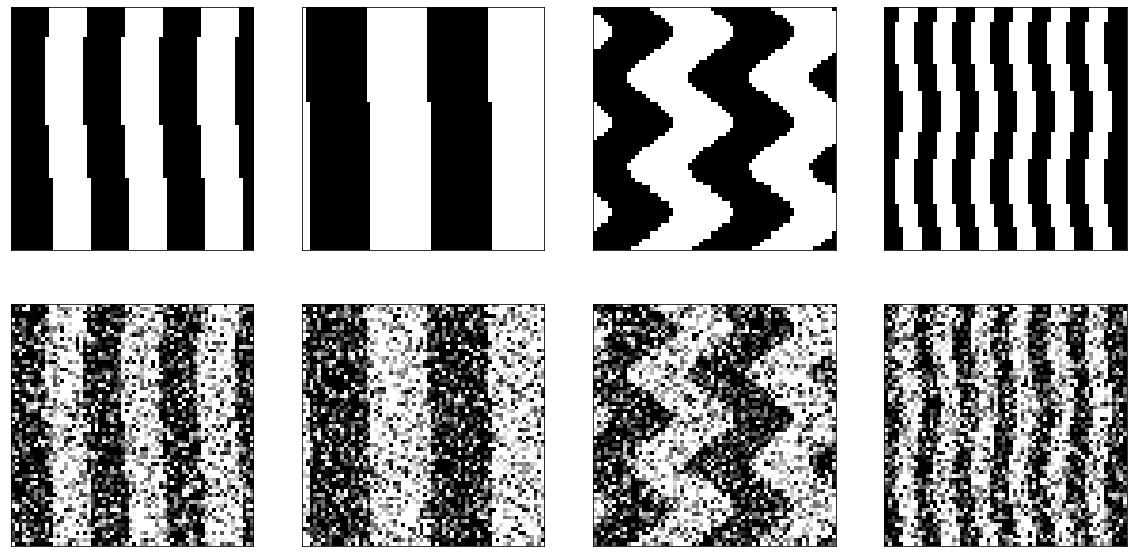

(7308, 64, 64, 1)
(811, 64, 64, 1)


In [ ]:
display(x_train, x_noise_train,4)
print(x_train.shape)
print(x_test.shape)

In [8]:
encoder_input = keras.Input(shape=(image_size, image_size,1))
fn = 64
# encoder
x = Conv2D(fn, (3, 3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(fn, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(fn, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(fn, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

encoder = Model(encoder_input, encoded)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928 

In [9]:
# decoder
decoder_input= Input(shape=(4,4, 1))

decoder = Conv2D(fn, (3, 3), activation='relu', padding='same')(decoder_input)
x = UpSampling2D((2, 2))(decoder)
x = Conv2D(fn, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(fn, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(fn, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
# x = Conv2D(fn, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_input, decoded)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 1)]         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          640       
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 64)         0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        3692

In [10]:
# auto encoder
auto_input = Input(shape=(image_size,image_size, 1))
encoded = encoder(auto_input)
decoded = decoder(encoded)

autoencoder = Model(auto_input, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
autoencoder.summary()
setattr(autoencoder, 'save', custom_save)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 model (Functional)          (None, 4, 4, 1)           112001    
                                                                 
 model_1 (Functional)        (None, 64, 64, 1)         112001    
                                                                 
Total params: 224,002
Trainable params: 224,002
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = autoencoder.fit(
     x=x_train,
     y=x_train,
     epochs=200,
     batch_size=64,
     shuffle=True,
     validation_data=(x_test, x_test),
     callbacks=callbacks_list,
 )


Epoch 1/200
115/115 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.7168WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ME592_FinalProject/Bestmodels/c16f64/compression_16_filter_64_epoch_01_loss_0.389_encoder/assets
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ME592_FinalProject/Bestmodels/c16f64/compression_16_filter_64_epoch_01_loss_0.389_decoder/assets
115/115 [==============================] - 9s 48ms/step - loss: 0.4782 - accuracy: 0.7168 - val_loss: 0.3892 - val_accuracy: 0.7860
Epoch 2/200
115/115 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.8371WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
INFO:tensorflow:

In [ ]:

history = autoencoder.fit(
    x=x_noise_train,
    y=x_train,
    epochs=200,
    batch_size=64,
    shuffle=True,
    validation_data=(x_noise_test, x_test),
    callbacks=callbacks_list,
)

In [ ]:
print((history.history['val_loss'][-1]))

0.03147110342979431


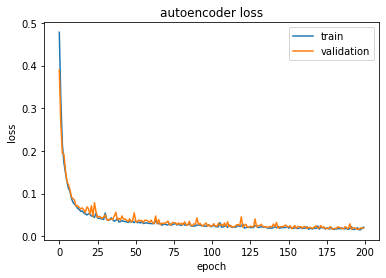

In [12]:
# all_hist_accuracy = [item for sublist in all_hist_accuracy for item in sublist]
# all_hist_val_accuracy = [item for sublist in all_hist_val_accuracy for item in sublist]
# all_hist_val_loss = [item for sublist in all_hist_val_loss for item in sublist]
# all_hist_loss = [item for sublist in all_hist_loss for item in sublist]

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('autoencoder loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(figure_name)
plt.show()

In [ ]:
# if gpu_devices:
#   tf.config.experimental.get_memory_usage('GPU:0')

In [13]:
encoder =  keras.models.load_model('/content/drive/Shareddrives/ME592_FinalProject/Bestmodels/c16f64/compression_16_filter_64_epoch_197_loss_0.016_encoder')
decoder =  keras.models.load_model('/content/drive/Shareddrives/ME592_FinalProject/Bestmodels/c16f64/compression_16_filter_64_epoch_197_loss_0.016_decoder')

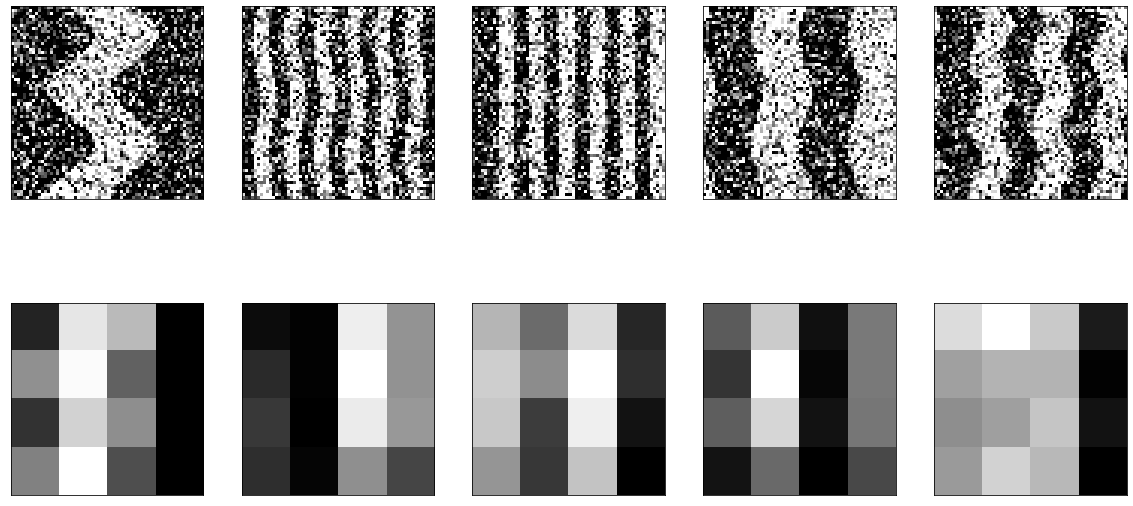

In [14]:
predictions = autoencoder.predict(x_test)
encoded = encoder.predict(x_noise_test)
decoded = decoder.predict(encoded)
display(x_noise_test, encoded, 5, image_width_1=64, image_height_1=64, image_width_2=4, image_height_2=4)

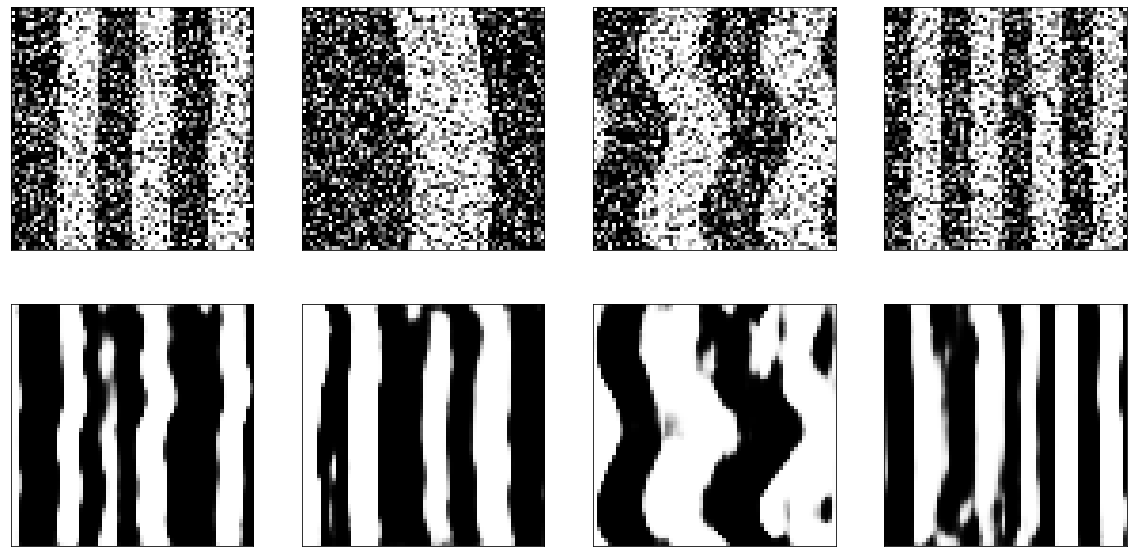

In [15]:
display(x_noise_test, decoded,4)

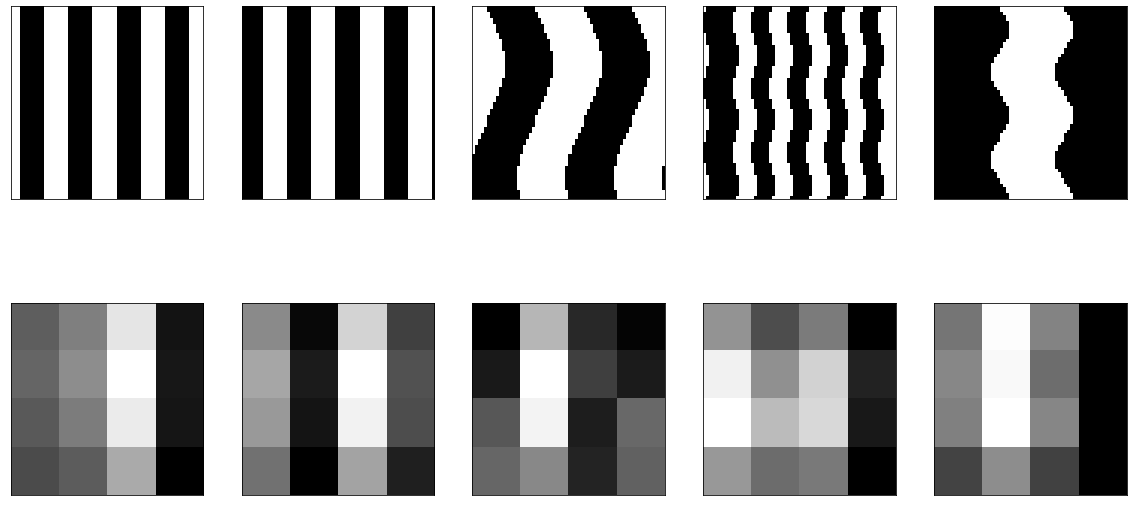

In [16]:
predictions = autoencoder.predict(x_test)
encoded = encoder.predict(x_test)
decoded = decoder.predict(encoded)
display(x_test, encoded, 5, image_width_1=64, image_height_1=64, image_width_2=4, image_height_2=4)

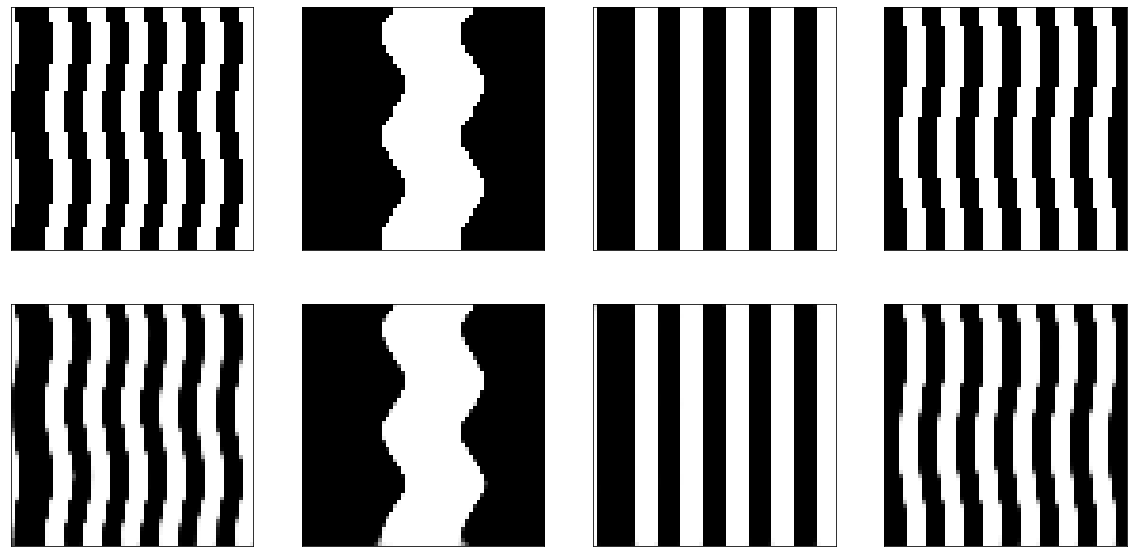

In [17]:
display(x_test, decoded,4)

In [ ]:
import csv

with open(figure_name.replace('png','csv'), 'wt') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(history.history['loss'])
    wr.writerow(history.history['val_loss'])

In [ ]:
# predictions = auto_loaded.predict(x_test)
# encoded = enco_loaded.predict(x_test)
# decoded = deco_loaded.predict(encoded)
# display(x_test, predictions, image_width=32, image_height=32)
# display(encoded, encoded, image_width=8, image_height=8)
# display(x_test, decoded, image_width=32, image_height=32)
